In [1]:
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import scipy.io as scio
from sklearn.decomposition import PCA
import pickle
from math_plds import *
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# from matplotlib.patches import FancyArrowPatch
# from mpl_toolkits.mplot3d import proj3d
from sklearn.cluster import KMeans

In [2]:
nld = 4
nts = 26187
nn = 300
nsd = 4
data = scio.loadmat('../data/compiled_dF033016.mat')
frameHz = data['FrameRateHz'][0, 0]  # frames per seconds
y = data['behavdF'].T
onsetframe = data['onsetFrame'].T[0].astype(np.int32)
onsettime = np.array(data['onsetFrame'].T[0]) / frameHz

resptime = data['resptime'].T[0]
respframe = onsetframe + resptime * frameHz
correct = data['correct'][0]

offsettime = onsettime + resptime + 2.75 + (4.85 - 2.75) * (1 - correct)
offsetframe = (offsettime * frameHz).astype(np.int32)

orientation = np.array(data['orient'][0], np.int8)
location = np.array((data['location'][0] + 1) // 2, np.int8)

u = np.zeros((y.shape[0], nsd))
for onf, off, ori, loc in zip(onsetframe, offsetframe, orientation, location):
    for frame in np.arange(onf, off, dtype=np.int32):
        u[frame] = np.array([ori*loc, (1-ori)*loc, ori*(1-loc), (1-ori)*(1-loc)])

stimuli = 1 * (1 - orientation) * location + 2 * orientation * (1 - location) + 3 * (1 - orientation) * (1 - location)

onsettoonset = onsetframe[1:] - onsetframe[:-1]

stimulicross = stimuli[np.where(offsetframe > y.shape[0] - nts)[0][0]:]
crossoffsetframe = offsetframe[-len(stimulicross):]-20000
crossonsetframe = (onsetframe[-len(stimulicross):]-20000).astype(np.int32)
ycross = y.flatten()[-nts*nn:]
ucross = u.flatten()[-nts*nsd:]

uvec = u[-nts:]


In [3]:
# normalizedstimgroups = {str(i):[] for i in range(nsd)}
# for stim, on in zip(stimuli, onsetframe):
#     normalizedstimgroups[str(stim)].append(ynormalized[int(on - 10): int(on + 10)])
# normalizedstimgroups = {str(i):np.array(normalizedstimgroups[str(i)]) for i in range(nsd)}

pre = 10
post = 40
center = onsetframe.copy()

ysilent = []
for t in center:
    for i in range(1, pre):
        ysilent.append(y[t-i])
baselines = np.mean(ysilent, axis=0)

normalizedstimgroups = {str(i):[] for i in range(nsd)}
for stim, t in zip(stimuli, center):
    normalizedstimgroups[str(stim)].append(y[int(t - pre): int(t + post)])
normalizedstimgroups = {str(i):np.array(normalizedstimgroups[str(i)]) for i in range(nsd)}

psthmeans = np.array([np.mean(normalizedstimgroups[str(j)], axis=0) for j in range(4)])
# psthmaxes = np.array([np.max(np.mean(normalizedstimgroups[str(j)], axis=0), axis=0) for j in range(4)])
# psthmaxdevs = np.array([np.max(np.abs(np.mean(normalizedstimgroups[str(j)], axis=0) - baselines), axis=0) for j in range(4)])
psthmaxes = np.array([np.max(np.abs(np.mean(normalizedstimgroups[str(j)], axis=0) - baselines), axis=0) for j in range(4)])
psthvectors = np.zeros(shape=(300, 4 * (pre + post)))
psthorders = np.argsort(-psthmaxes, axis=0).T
for i in range(300):
    j=0
    for o in psthorders[i]:
        psthvectors[i, (pre + post)*j:(pre + post)*(j+1)] += psthmeans[o].T[i]
        j += 1

for i in range(len(psthvectors)):
    psthvectors[i] /= np.max(psthvectors[i])


In [4]:
# order according to independent stimuli conditions. 
# Note that stimuli = 0: loc=1 ori=1
#           stimuli = 1: loc=1 ori=0
#           stimuli = 2: loc=0 ori=1
#           stimuli = 3: loc=0 ori=0

psthlocmaxes = np.array([np.max(psthmaxes[[0, 1]], axis=0), np.max(psthmaxes[[2, 3]], axis=0)])
psthorimaxes = np.array([np.max(psthmaxes[[0, 2]], axis=0), np.max(psthmaxes[[1, 3]], axis=0)])
psthlocorders = np.argsort(-psthlocmaxes, axis=0).T
psthoriorders = np.argsort(-psthorimaxes, axis=0).T
stimulilookuptable = np.array([[0, 1], [2, 3]])
normalizedpsthstimsortvectors = np.zeros(shape=(300, 4*(pre + post)))
psthstimsortvectors = np.zeros(shape=(300, 4*(pre + post)))

for i in range(300):
    psthstimsortvectors[i] += np.concatenate([
                                      psthmeans[stimulilookuptable[psthlocorders[i, 0], psthoriorders[i, 0]]].T[i],
                                      psthmeans[stimulilookuptable[psthlocorders[i, 0], psthoriorders[i, 1]]].T[i],                           
                                      psthmeans[stimulilookuptable[psthlocorders[i, 1], psthoriorders[i, 0]]].T[i],                            
                                      psthmeans[stimulilookuptable[psthlocorders[i, 1], psthoriorders[i, 1]]].T[i]                          
                                      ])
#     normalizedpsthstimsortvectors[i] = psthstimsortvectors[i]/np.max(psthstimsortvectors[i])
    normalizedpsthstimsortvectors[i] = (psthstimsortvectors[i] - np.mean(psthstimsortvectors[i]))/np.std(psthstimsortvectors[i])

/home/bkorkor/miniconda3/envs/plds/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


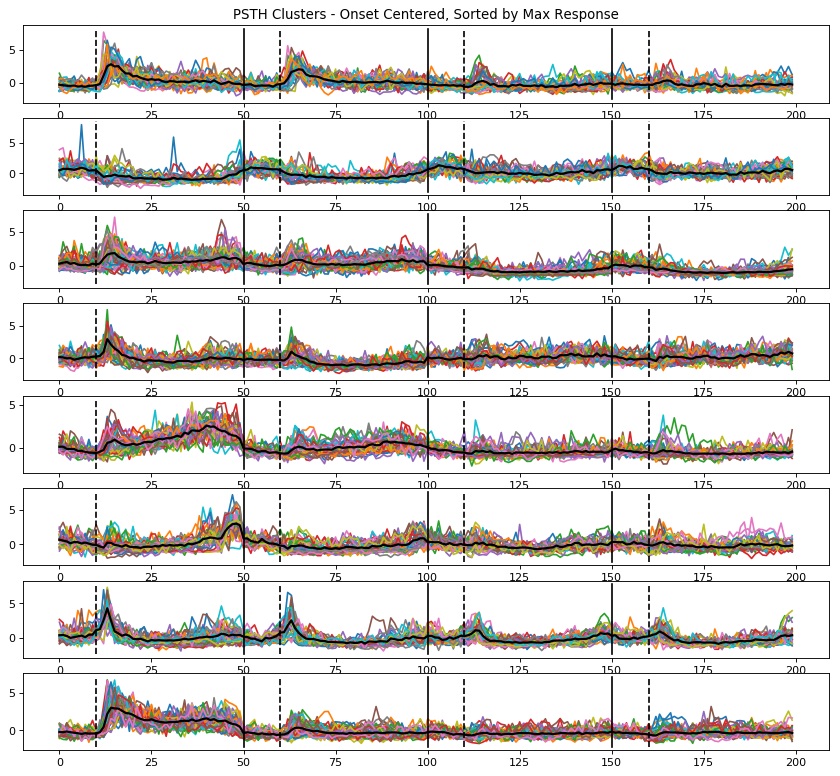

In [5]:
nclusters = 8
sortedstimkmeans = KMeans(n_clusters=nclusters).fit(normalizedpsthstimsortvectors)
stimsortedkmeanpredictions = sortedstimkmeans.predict(normalizedpsthstimsortvectors)

plt.figure(figsize=(13, 12), dpi= 80, facecolor='w', edgecolor='w')
plt.subplot(nclusters, 1, 1)
plt.title('PSTH Clusters - Onset Centered, Sorted by Max Response')
clustermeans = [[] for i in range(nclusters)]
for i in range(300):
    clustermeans[stimsortedkmeanpredictions[i]].append(normalizedpsthstimsortvectors[i])
    plt.subplot(nclusters, 1, stimsortedkmeanpredictions[i]+1)
    plt.plot(normalizedpsthstimsortvectors[i])

for i in range(nclusters):
    plt.subplot(nclusters, 1, i+1)
    plt.plot(np.mean(clustermeans[i], axis=0), 'k', linewidth=2)
    lims = plt.ylim()
    for j in range(1, nsd):
        plt.plot([j*(pre + post), j*(pre + post)], lims, 'k-')
    for j in range(nsd):
        plt.plot([pre + j* (pre + post), pre + j*(pre + post)], lims, 'k--')
plt.show()

/home/bkorkor/miniconda3/envs/plds/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


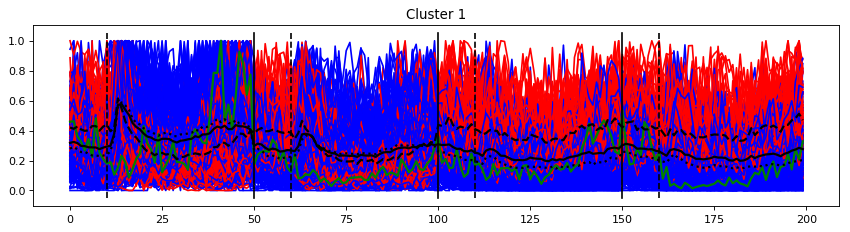

/home/bkorkor/miniconda3/envs/plds/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/bkorkor/miniconda3/envs/plds/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


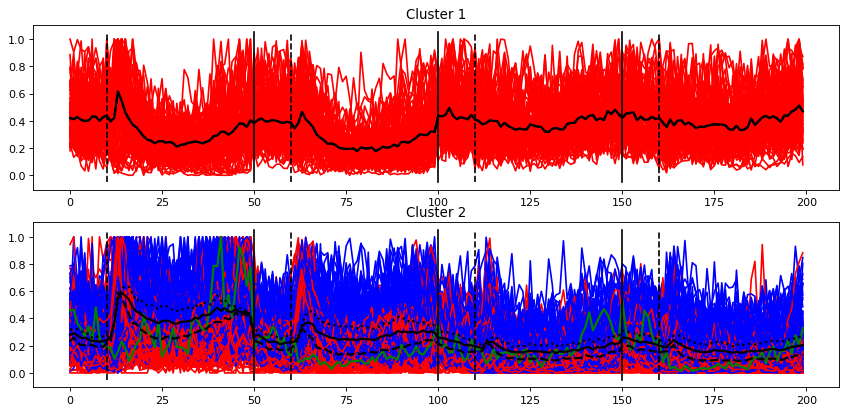

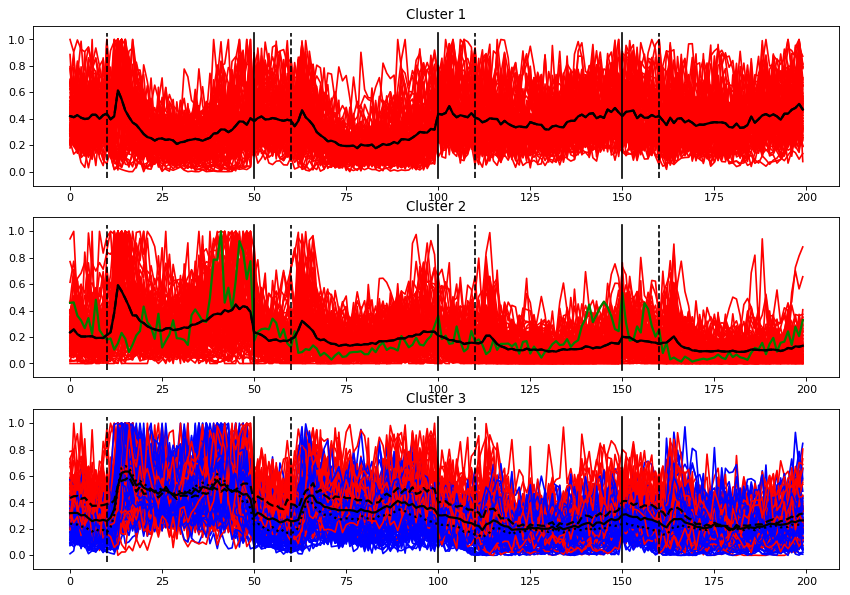

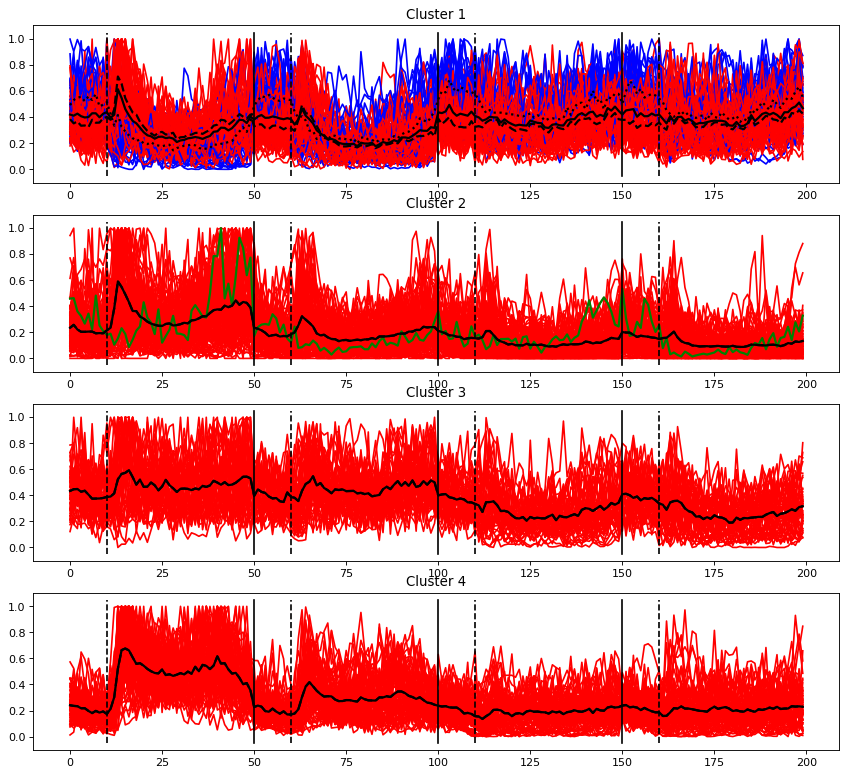

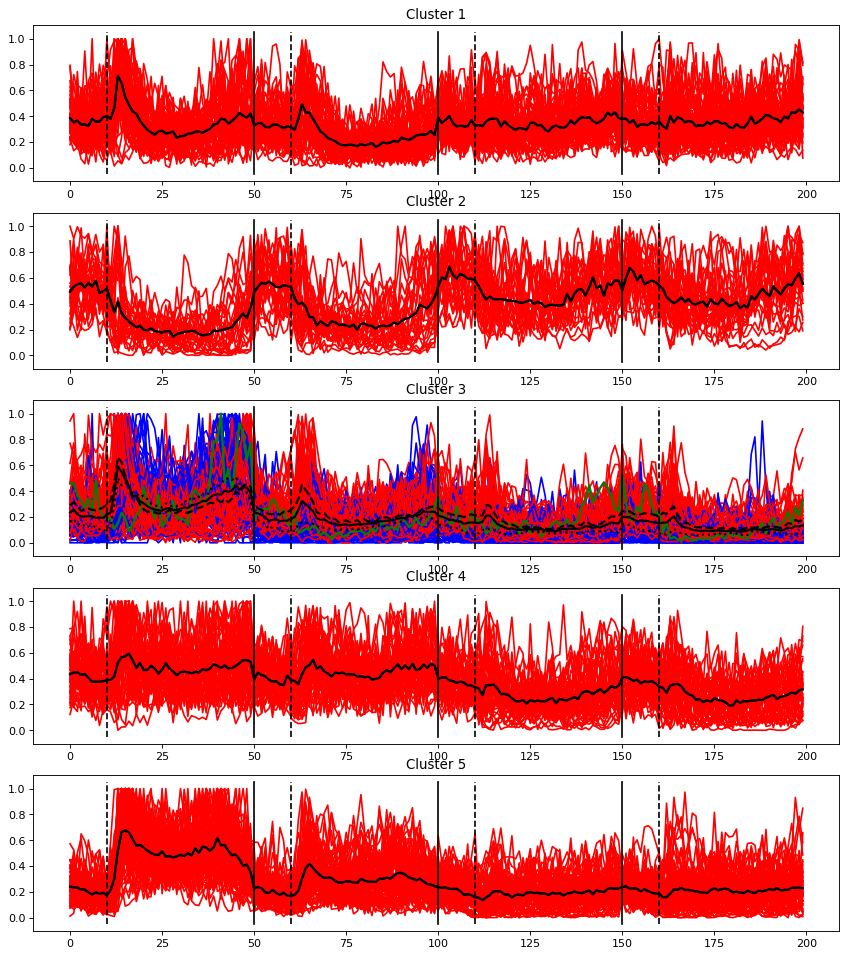

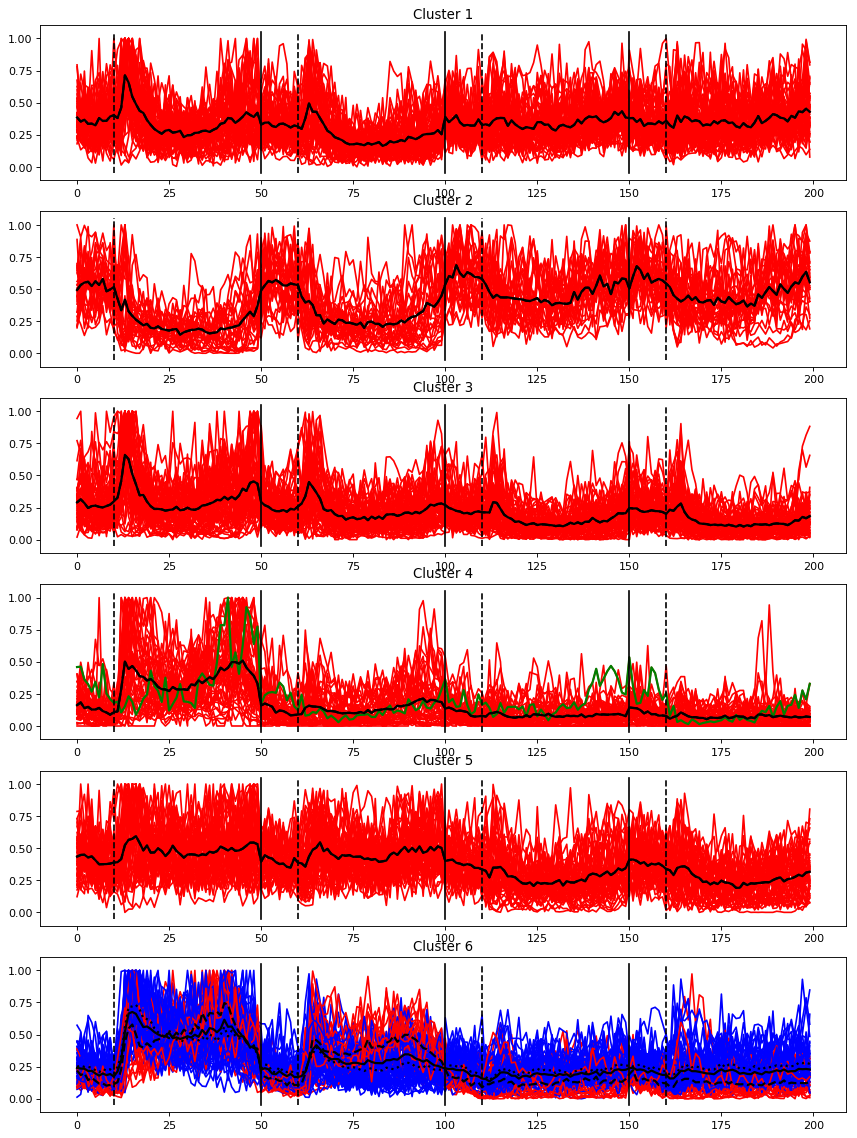

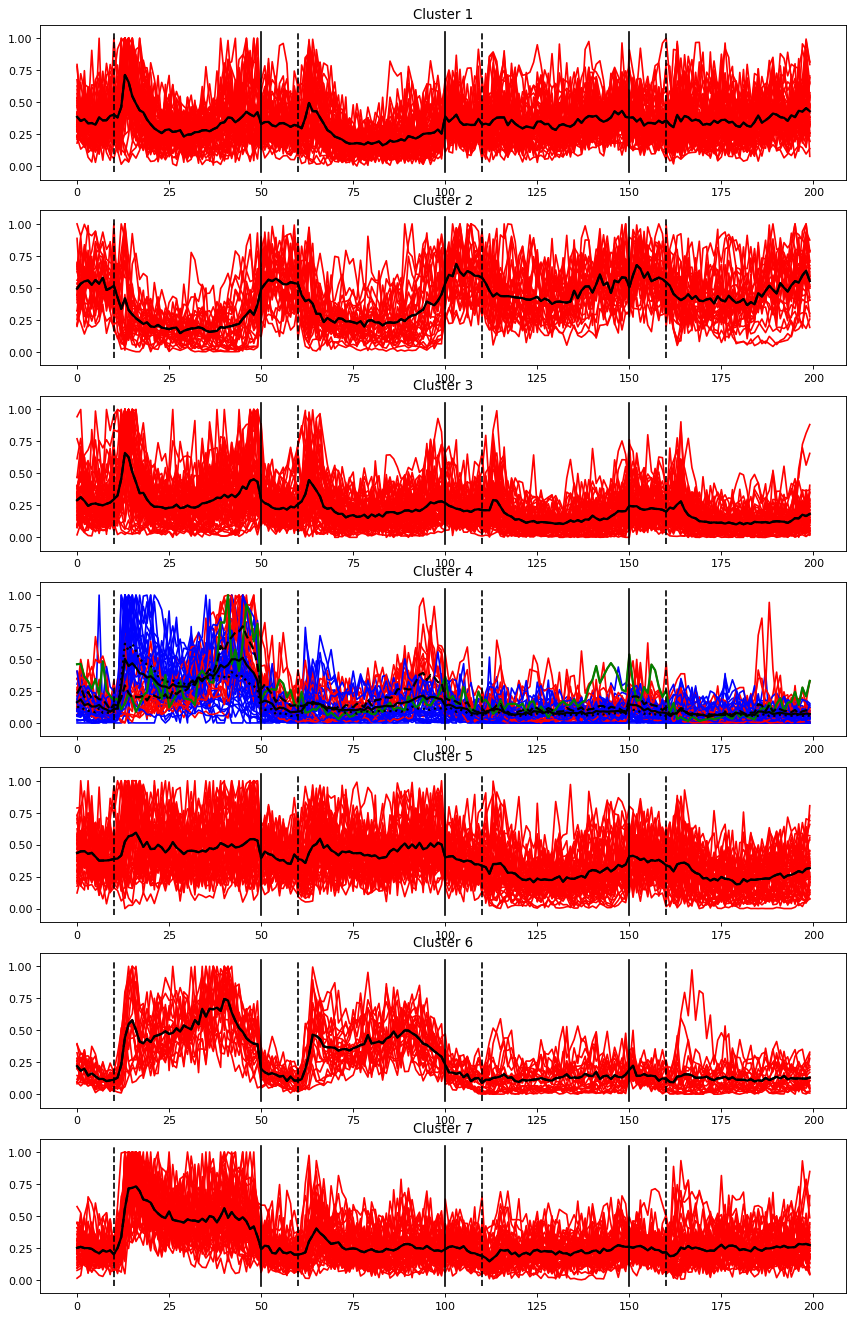

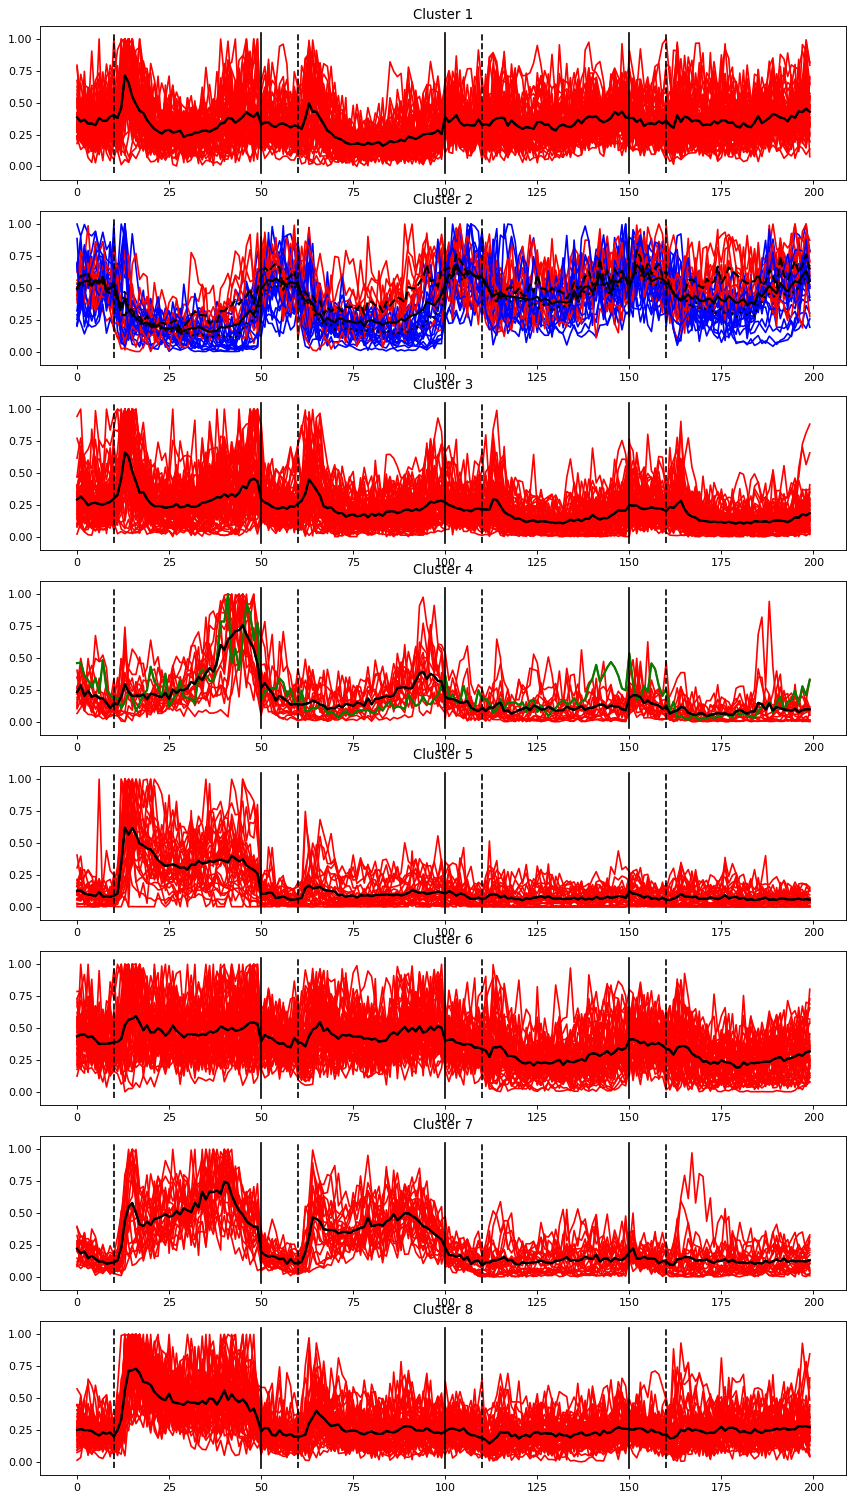

In [14]:
# Hierarchical Clustering
inspectneurons = [100]
pastclusters = None
Z = linkage(normalizedpsthstimsortvectors, 'ward')
clusters = [fcluster(Z, k, criterion='maxclust') for k in range(1, 10)]
changenumber = None
for c in range(len(clusters[:-1])):
    clusterinds = []
    for cluster in clusters[c]:
        if not cluster in clusterinds:
            clusterinds.append(cluster)
    clusterinds = sorted(clusterinds)
    
    for changenumber in range(1, c+2):
#         print('changenumber = {}'.format(changenumber))
        if [n for n,x in enumerate(clusters[c]) if x==changenumber] != [n for n,x in enumerate(clusters[c+1]) if x==changenumber]:
            break
    
    plt.figure(figsize=(13, 3 * len(clusterinds)), dpi= 80, facecolor='w', edgecolor='k')
    clustermeans = [[] for i in range(len(clusterinds))]
    changeclustermeans = [[[] for i in range(len(clusterinds))] for _ in range(2)]
    for i in range(300):
        if clusters[c][i] <= changenumber:
            adjustedfuturenumber = clusters[c+1][i]
        else:
            adjustedfuturenumber = clusters[c+1][i] - 1

        if clusters[c][i] == adjustedfuturenumber:
            color = 'r'
            clustermeans[clusterinds.index(clusters[c][i])].append(normalizedpsthstimsortvectors[i])
            changeclustermeans[0][clusterinds.index(clusters[c][i])].append(normalizedpsthstimsortvectors[i])
        else:
            color = 'b'
            clustermeans[clusterinds.index(clusters[c][i])].append(normalizedpsthstimsortvectors[i])
            changeclustermeans[1][clusterinds.index(clusters[c][i])].append(normalizedpsthstimsortvectors[i])
            
        plt.subplot(np.max(clusters[c]), 1, clusterinds.index(clusters[c][i])+1)
        plt.plot(normalizedpsthstimsortvectors[i], color)
    
    for i in inspectneurons:
        plt.subplot(np.max(clusters[c]), 1, clusterinds.index(clusters[c][i])+1)
        plt.plot(normalizedpsthstimsortvectors[i], 'g', linewidth=2)

    for i in range(len(clusterinds)):
        plt.subplot(len(clusterinds), 1, i+1)
        plt.gca().set_title('Cluster {}'.format(clusterinds[i]))
        plt.plot(np.mean(clustermeans[i], axis=0), 'k', linewidth=2)
        plt.plot(np.mean(changeclustermeans[0][i], axis=0), 'k--', linewidth=2)
        plt.plot(np.mean(changeclustermeans[1][i], axis=0), 'k:', linewidth=2)
        lims = plt.ylim()
        for j in range(1, nsd):
            plt.plot([j*(pre + post), j*(pre + post)], lims, 'k-')
        for j in range(nsd):
            plt.plot([pre + j * (pre + post), pre + j * (pre + post)], lims, 'k--')
    plt.show()

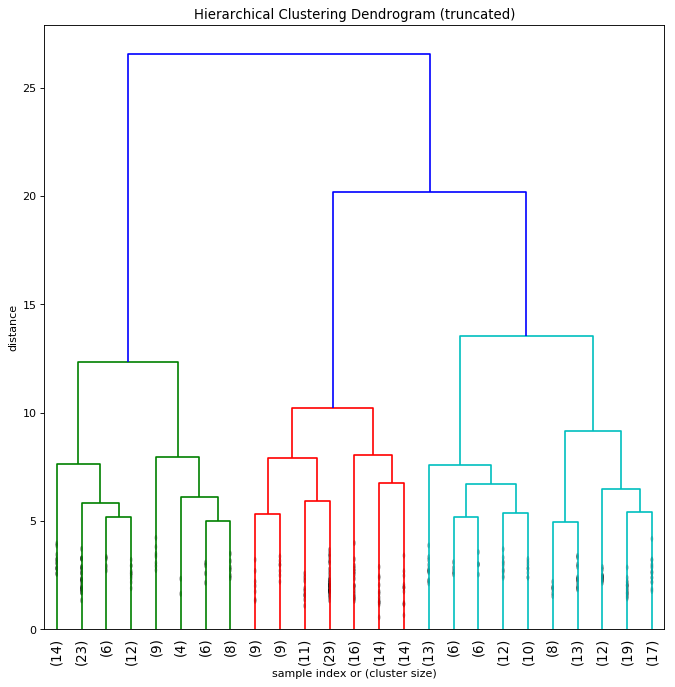

In [171]:
plt.figure(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=25,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()